## Select Representative RCAs

### Summary
Select a few representative RCAs from each group considering geographic subregions and RCAs with previous sampling.

### Methods
* Load classified RCAs calculated in classify-rcas.ipynb
* Uses the squared distance in principle component space between each RCA and its cluster centroid as a measure of cluster representativity.
* RCAs are selected by prioritizing previously sampled RCAs (in/out RCA transects) and then by selecting the RCAs with the lowest squared distances for each cluster.
* The number of representative RCAs are then reduced by randomly sampling using the occurrence of previous sampling and the relative rarity of the cluster for weighting. Thus preferentially selecting RCAs with previous samples and those from less well represented clusters. This helps to ensure that are clusters are represented evenly.
* Outlier RCAs are also identified by locating RCAs that have very high values in a given variable in only 3 or less RCAs and very low values in all other RCAs (highly skewed distribution).
* The RCA with the maximum value for tidal current speed is also considered an outlier because this important variable wasn't included in the clustering analysis due to data quality concerns in the QCS region.

### Figures
* RCAs are visualized in both principle component (PC1 and PC2) and geographic (x and y) space.
* The distribution and mean value of the variables across RCAs are plotted by cluster.

In [1]:
# Import necessary modules
import numpy as np # for numpy array 
from matplotlib import pyplot as plt # for base plots
import matplotlib as mpl # for colour map customization
import seaborn as sns # for strip plots
from pathlib import Path # for handling file paths
import pandas as pd # for dataframe
import geopandas as gp # for spatial dataframes

In [2]:
# Load RCA polys with variables
rcas_polys_variables = "/mnt/d/Projects/RCA-monitoring/Classification/All/Shapefiles/All_RCAs_Variables.shp"
rca_polys = gp.read_file(rcas_polys_variables)

# Load coastline for maps
coast = "/mnt/d/Spatial/Coastlines/coast_sim.shp"
coast_polys = gp.read_file(coast)

# Convert previous sampling to numbers
rca_polys['PrevSample'] = rca_polys['PrevSample'].replace({'No' : '2.No', 'Yes' : '1.Yes'})

# Set cluster to factor
rca_polys['Cluster'] = rca_polys['Cluster'].astype('category')

# Show column names
rca_polys.columns

Index(['Name', 'Region', 'SubRegion', 'Cluster', 'PrevSample', 'Area', 'X',
       'Y', 'CenterEdge', 'EdgeArea', 'NearestRCA', 'Depth', 'Slope',
       'Complexity', 'Rock', 'Exposure', 'Tidal', 'BathyQuali', 'Kelp',
       'Eelgrass', 'SpongeReef', 'Population', 'Near_Base', 'Coast_Infr',
       'Trawl_Fish', 'Traps_Fish', 'Crab_trap', 'Prawn_trap', 'PCA1', 'PCA2',
       'SquaredDis', 'geometry'],
      dtype='object')

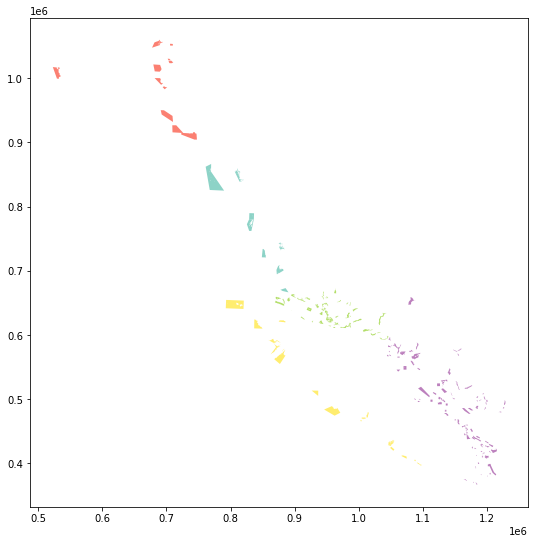

In [3]:
# Map sub regions
rca_polys.plot(column='SubRegion', cmap='Set3', figsize=(9,9))
plt.show()

In [4]:
# Map previously sampled RCAs (red)
rca_polys.plot(column='PrevSample', cmap='Set1', figsize=(9,9))
plt.show()

In [5]:
# Get number of clusters
k = rca_polys['Cluster'].nunique()
k

4

In [6]:
# Set consistent cluster colours all subsequent for plots
cbPalette = ["#CC79A7", "#E69F00", "#56B4E9", "#009E73"]
my_cmap = mpl.colors.ListedColormap(cbPalette)
sns.set_palette(sns.color_palette(cbPalette))

In [7]:
# Select representative RCAs
# Selects 'num' RCAs from each cluster and each region
# First prioritizes RCAs that have been previously sample and
# secondly those that are close to the centroid of clusters in PCA space

# Number of RCAs to select from each cluster and each region
num = 3

# Sort by previously sampled and squared distance
datord = rca_polys.sort_values(by=['PrevSample','SquaredDis'])

# Get 'num' number RCAs for each group and each subregion
rep = datord.groupby(['SubRegion','Cluster']).\
head(num).sort_values(by=['SubRegion','Cluster','PrevSample'])

# Print
print('Number of representative RCAs = ' + str(len(rep)), "\n" )
print( rep['Cluster'].value_counts()) 
rep.loc[:,['Name', 'SubRegion', 'PrevSample', 'Cluster']]

Number of representative RCAs = 33 

1    11
3    11
0     8
2     3
Name: Cluster, dtype: int64


Name SubRegion PrevSample Cluster
73                               Kitasu Bay        CC       2.No       1
49                           Fish Egg Inlet        CC       2.No       1
131                             Smith Sound        CC       2.No       3
135                           Storm Islands        CC       2.No       3
153                 West Aristazabal Island        CC       2.No       3
134                         Stephens Island        NC       2.No       3
154                       West Banks Island        NC       2.No       3
100                           Otter Passage        NC       2.No       3
39           Dickson - Polkinghorne Islands       QCS      1.Yes       0
127                             Shelter Bay       QCS      1.Yes       0
79                       Lower Clio Channel       QCS      1.Yes       0
149                         Viscount Island       QCS      1.Yes       1
55                          Goletas Channel       QCS      1.Yes       1
139                          Thompson Sound       QCS       2.No       1
98                            Numas Islands       QCS       2.No       3
31          D'Arcy Island to Beaumont Shoal        SS      1.Yes       0
84                              Maud Island        SS       2.No       0
41              Discovery - Chatham Islands        SS       2.No       0
141                            Thurston Bay        SS      1.Yes       1
120  Sabine Channel-Jervis-Jedediah Islands        SS      1.Yes       1
40                              Dinner Rock        SS      1.Yes       1
144                      Trincomali Channel        SS      1.Yes       2
103                                Pam Rock        SS      1.Yes       2
111                    Prevost Island North        SS      1.Yes       2
101                              Oyster Bay        SS       2.No       3
15                     Broken Islands Group      WCVI      1.Yes       0
148          Vargus Island to Dunlap Island      WCVI       2.No       0
124                          Saranac Island      WCVI      1.Yes       1
6                             Bedwell Sound      WCVI      1.Yes       1
68                            Holberg Inlet      WCVI       2.No       1
16                               Brooks Bay      WCVI      1.Yes       3
142                                 Topknot      WCVI      1.Yes       3
25                            Checleset Bay      WCVI      1.Yes       3

In [8]:
# Reduce number of representative RCAs
# Create weights for sampling representative RCAs for thinning
# Weighting prioritizes previously less common clusters

# Calculate cluster frequency counts for weights (inverse weighted)
rep['freq'] = np.power(rep.groupby('Cluster')['Cluster'].transform('count'),3)
rep['weights'] = 1 / rep['freq']
rep['weights'] = rep['weights']/rep['weights'].min()

# For each subregion, select by weighted sampling
# Sample to reduce the number of representative RCAs
nreps = pd.DataFrame()
for i in rep['SubRegion'].unique():
    tmp = rep[rep['SubRegion'] == i]
    r=tmp.sample(n=num, weights=tmp.weights, random_state=1)
    nreps = pd.concat([nreps, r])

# Print
print('Number of representative RCAs = ' + str(len(nreps)), "\n" )
print( nreps['Cluster'].value_counts()) 
nreps.loc[:,['Name', 'SubRegion', 'PrevSample', 'Cluster']]
#rep.loc[:,['Name', 'freq', 'weights', 'Cluster']]

Number of representative RCAs = 15 

0    5
3    5
1    3
2    2
Name: Cluster, dtype: int64


Name SubRegion PrevSample Cluster
131                      Smith Sound        CC       2.No       3
135                    Storm Islands        CC       2.No       3
73                        Kitasu Bay        CC       2.No       1
154                West Banks Island        NC       2.No       3
100                    Otter Passage        NC       2.No       3
134                  Stephens Island        NC       2.No       3
127                      Shelter Bay       QCS      1.Yes       0
149                  Viscount Island       QCS      1.Yes       1
39    Dickson - Polkinghorne Islands       QCS      1.Yes       0
103                         Pam Rock        SS      1.Yes       2
111             Prevost Island North        SS      1.Yes       2
31   D'Arcy Island to Beaumont Shoal        SS      1.Yes       0
148   Vargus Island to Dunlap Island      WCVI       2.No       0
68                     Holberg Inlet      WCVI       2.No       1
15              Broken Islands Group      WCVI      1.Yes       0

In [9]:
# Look for outliers
# Variables with a skewed distribution
# Look for RCAs with very high values (when other RCAs are all low or zero)
# Exception for tidal current which was not included as a cluster variable,
# assign outlier to RCA with maximum tidal current value

# Variables to look for outliers in
Vars  = ['Area', 'NearestRCA', 'EdgeArea', 'Depth', 'Slope', 'Complexity', 'Rock',
         'Exposure', 'Tidal', 'Kelp', 'Eelgrass', 'SpongeReef', 'Population', 
         'Near_Base', 'Coast_Infr', 'Trawl_Fish', 'Traps_Fish']

# Load scaled variables dataframe
scaled_df = pd.read_csv('All/all_RCAs_clusters_scaled.csv', index_col=0)  

# Start outlier df
outs = pd.DataFrame()

# Return RCA with max value when less than or equal to 3 RCAs (roughly 2%) have scaled values greater than 0.5
for i in Vars :
    inds = scaled_df[scaled_df[i] > 0.5].index
    if i == 'Tidal' :
        inds = scaled_df[scaled_df[i] == 1].index
    if len(inds) <=3 :
        tmp = rca_polys.loc[inds,:]
        tmp = tmp[tmp[i] == max(tmp[i])]
        tmp['OutlierVariable'] = i
        outs = pd.concat([outs, tmp])

# Remove any duplicates with representative RCAs if they are present
overlap = np.array( ~outs[['Name']].isin(nreps[['Name']]) )
outs = outs[overlap]

# Combine with rep table
allreps = pd.concat([nreps, outs])

# Get representative RCAs from scaled data
allreps_scaled = scaled_df.iloc[allreps.index]

# Print
print('Number of outlier RCAs = ' + str(len(outs)) )
print('Number of representative RCAs (incl. outliers) = ' + str(len(allreps)), "\n" )
print( allreps['Cluster'].value_counts()) 
allreps.loc[:,['Name', 'SubRegion', 'PrevSample', 'Cluster',  "OutlierVariable"]]

Number of outlier RCAs = 5
Number of representative RCAs (incl. outliers) = 20 

0    6
3    6
1    5
2    3
Name: Cluster, dtype: int64


Name SubRegion PrevSample Cluster  \
131                      Smith Sound        CC       2.No       3   
135                    Storm Islands        CC       2.No       3   
73                        Kitasu Bay        CC       2.No       1   
154                West Banks Island        NC       2.No       3   
100                    Otter Passage        NC       2.No       3   
134                  Stephens Island        NC       2.No       3   
127                      Shelter Bay       QCS      1.Yes       0   
149                  Viscount Island       QCS      1.Yes       1   
39    Dickson - Polkinghorne Islands       QCS      1.Yes       0   
103                         Pam Rock        SS      1.Yes       2   
111             Prevost Island North        SS      1.Yes       2   
31   D'Arcy Island to Beaumont Shoal        SS      1.Yes       0   
148   Vargus Island to Dunlap Island      WCVI       2.No       0   
68                     Holberg Inlet      WCVI       2.No       1   
15              Broken Islands Group      WCVI      1.Yes       0   
153          West Aristazabal Island        CC       2.No       3   
115                       Race Rocks        SS       2.No       0   
125        Savoie Rocks - Maude Reef        SS       2.No       1   
105                   Passage Island        SS       2.No       2   
55                   Goletas Channel       QCS      1.Yes       1   

    OutlierVariable  
131             NaN  
135             NaN  
73              NaN  
154             NaN  
100             NaN  
134             NaN  
127             NaN  
149             NaN  
39              NaN  
103             NaN  
111             NaN  
31              NaN  
148             NaN  
68              NaN  
15              NaN  
153            Area  
115           Tidal  
125        Eelgrass  
105      SpongeReef  
55       Trawl_Fish

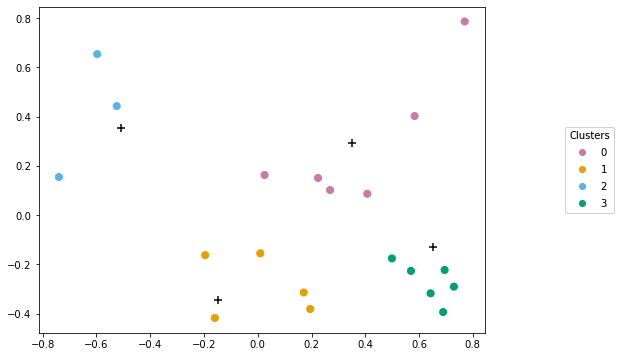

In [10]:
# Plot representative RCAs clusters with PCA 1 and 2 axes
fig, ax = plt.subplots()
scatter = ax.scatter(allreps['PCA1'], allreps['PCA2'], c=allreps['Cluster'], s=50, cmap=my_cmap)
centroids = np.load('All/centroids.npy')
ax.scatter(centroids[:,0],centroids[:,1], s=60, color="black", marker="+")
# produce a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(),  bbox_to_anchor=(1.3, 0.5), 
                   loc="center right", title="Clusters")
# Put a legend to the right of the current axis
ax.add_artist(legend)
fig.set_size_inches(8, 6)
fig.show()

/home/nephinj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/nephinj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/nephinj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



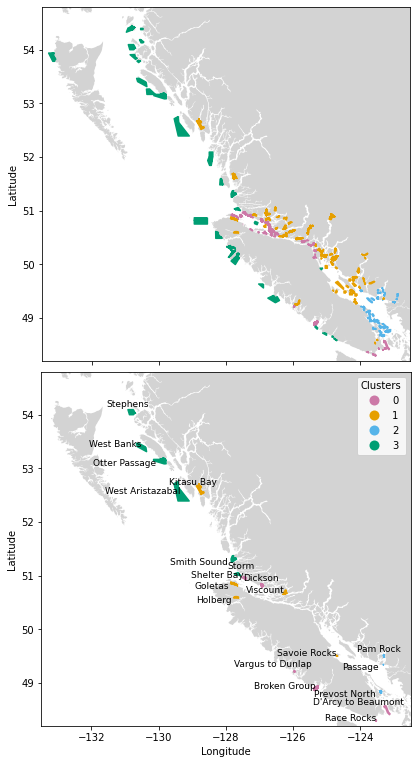

In [27]:
# Map RCAs by cluster, all and reps

# Edge colours
norm = mpl.colors.Normalize(0,3)
z1 = rca_polys.Cluster
edgecols1 = my_cmap(norm(z1))
z2 = allreps.Cluster
edgecols2 = my_cmap(norm(z2))

# start plot
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7, 10))
fig.tight_layout(pad=-1) 
# all RCAs
coast_polys.to_crs(epsg=4326).plot(ax=ax1, color="#D3D3D3")
rca_polys.to_crs(epsg=4326).plot(column='Cluster', cmap=my_cmap, linewidth=1.5, edgecolor=edgecols1, 
                                legend=False, ax=ax1)
ax1.set(xlabel="", ylabel="Latitude", xlim=(-133.5,-122.5), ylim=(48.2,54.8))
ax1.tick_params('x', labelbottom=False)

# rep RCAs
coast_polys.to_crs(epsg=4326).plot(ax=ax2, color="#D3D3D3")
allreps.to_crs(epsg=4326).plot(column='Cluster', cmap=my_cmap, linewidth=1.5, edgecolor=edgecols2, 
                               legend=True, legend_kwds={'title': 'Clusters'}, ax=ax2)
ax2.set(xlabel="Longitude", ylabel="Latitude", xlim=(-133.5,-122.5), ylim=(48.2,54.8))

# Seperate dataset to make labels offset, not overlap
d = allreps.copy()
d['y_coords'] = d.centroid.y
d = d.sort_values(by=['y_coords'])
d = d.replace(to_replace=r' Islands', value='', regex=True)
d = d.replace(to_replace=r' Island', value='', regex=True)
d = d.replace(to_replace=r' Inlet', value='', regex=True)
d = d.replace(to_replace=r' Channel', value='', regex=True)
d = d.replace(to_replace=r' Shoal', value='', regex=True)
d = d.replace(to_replace=r'Dickson - Polkinghorne', value='Dickson', regex=True)
d = d.replace(to_replace=r'Savoie Rocks - Maude Reef', value='Savoie Rocks', regex=True)
d1 = d.iloc[0::3, :]
d2 = d.iloc[1::3, :]
d3 = d.iloc[2::3, :]
for x, y, label in zip(d1.to_crs(epsg=4326).centroid.x, d1.to_crs(epsg=4326).centroid.y, d1.Name):
    ax2.annotate(label, xy=(x, y),  xytext=(0, 0), textcoords="offset points", 
                 horizontalalignment='right', size=9)
for x, y, label in zip(d2.to_crs(epsg=4326).centroid.x, d2.to_crs(epsg=4326).centroid.y, d2.Name):
    ax2.annotate(label, xy=(x, y),  xytext=(17, 5), textcoords="offset points", 
                 horizontalalignment='right', size=9)
for x, y, label in zip(d3.to_crs(epsg=4326).centroid.x, d3.to_crs(epsg=4326).centroid.y, d3.Name):
    ax2.annotate(label, xy=(x, y),  xytext=(-5, -5), textcoords="offset points", 
                 horizontalalignment='right', size=9)

plt.show()
fig.savefig("Figures/Clusters_RepRCAs_Map.png", dpi=300,  facecolor='white', bbox_inches='tight')

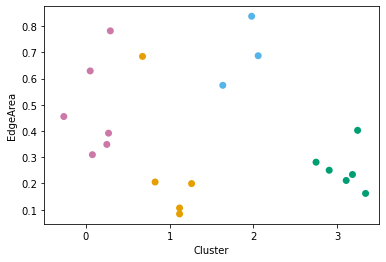

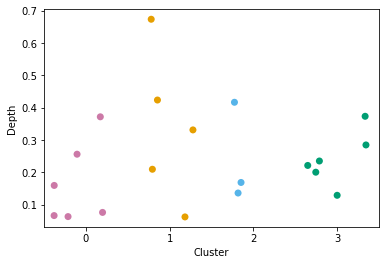

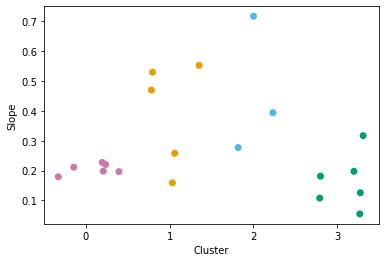

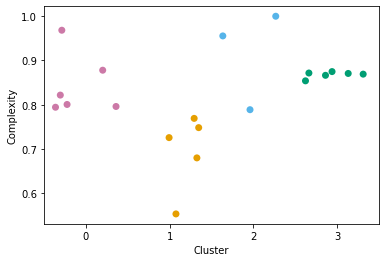

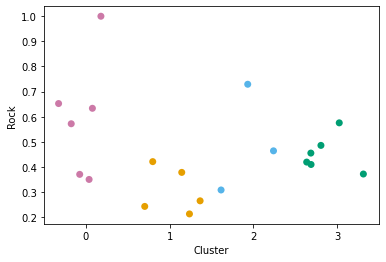

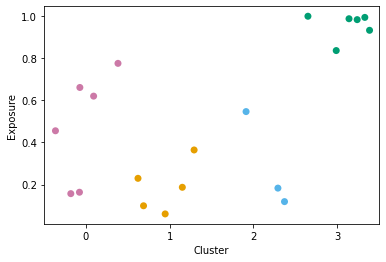

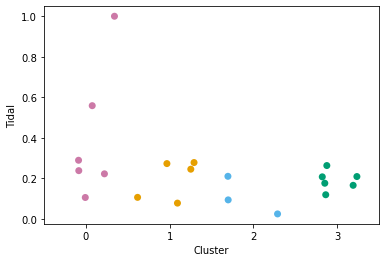

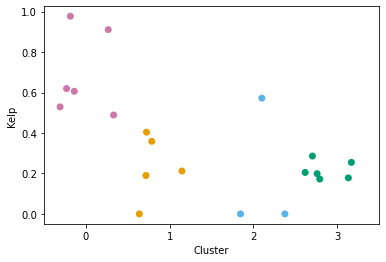

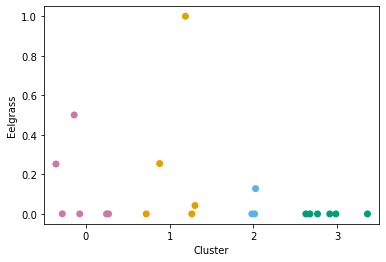

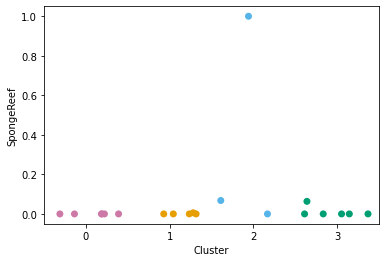

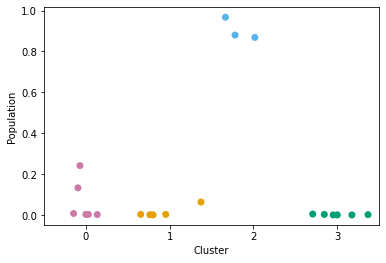

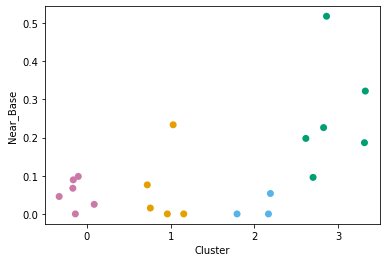

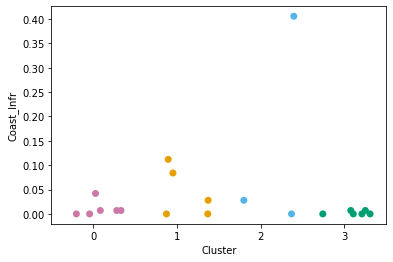

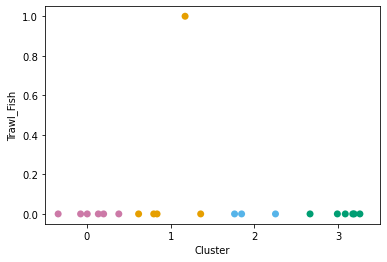

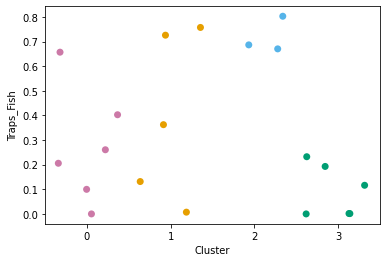

In [12]:
# Plot representative RCAs cluster by all variables (scaled)
# Not just the variables used for clustering
for i in Vars:
    plt.figure()
    sns.stripplot(x='Cluster', y=i, data=allreps_scaled, jitter=0.4, s=7)

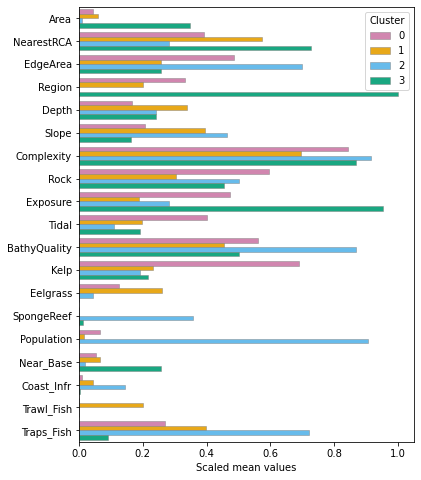

In [13]:
# Calculate mean values (for representative RCAs only) of variables for each cluster

# For scaled variables (0 to 1)
rep_means_scaled = allreps_scaled.groupby('Cluster').agg(['mean']).round(3).transpose().droplevel(level=1).reset_index()
rep_means_scaled.rename(columns={'index':'Variable'}, inplace=True)

# Plot scaled mean value for each variable by cluster
rep_means_scaled_melted = rep_means_scaled.melt(id_vars=['Variable'], value_vars=list(rep_means_scaled.columns[1:]))
plt.figure(figsize=(6, 8))
ax=sns.barplot(y='Variable', x='value', hue="Cluster", data=rep_means_scaled_melted,
               saturation=1, edgecolor='grey', alpha = 0.9, linewidth=0.5)
ax.set(ylabel='', xlabel='Scaled mean values')
fig.show()

In [14]:
# Export representative RCA polygon with variables as attributes

# Re-order columns to a logical order
rep_rcas = allreps[['Name','geometry','Region','SubRegion', 'Cluster', 'OutlierVariable',
                   'PrevSample', 'Area','X','Y','CenterEdge','EdgeArea','NearestRCA',
                   'Depth','Slope','Complexity','Rock','Exposure','Tidal','BathyQuali',
                   'Kelp','Eelgrass','SpongeReef','Population','Near_Base','Coast_Infr',
                   'Trawl_Fish','Traps_Fish','Crab_trap','Prawn_trap', 
                   'PCA1', 'PCA2', 'SquaredDis']]

# Write attributes to csv
allreps_pd = pd.DataFrame(rep_rcas.drop('geometry', axis=1))
allreps_pd.to_csv('All/representative_RCAs.csv', index=True)  
allreps_scaled.to_csv('All/representative_RCAs_scaled.csv', index=True)  

# Convert cluster back to integer for saving as shapefile
rep_rcas['Cluster'] = rep_rcas['Cluster'].astype(int)

# Write geodataframe as shapefile
rep_rca_file = "/mnt/d/Projects/RCA-monitoring/Classification/All/Shapefiles/Representative_RCAs.shp"
rep_rcas.to_file(rep_rca_file)

/home/nephinj/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
